<a href="https://colab.research.google.com/github/morwald/ada_project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of gender distribution in UK's leading newspapers

This notebook serves as a first presentation of our project for milestone 2. It is structured and written in such  a way that we can directly continue on it for milestone 3.

## Content
1. [Setup](#setup)   
    1.1 [Imports](#imports)  
    1.2 [Data paths](#data_paths)   
    1.3 [Utility functions](#utility_functions)   
2. [Data preparation and cleaning](#data_prep)    
    2.1 [Columns and rows selection](#cols_rows_select)  
    2.2 [News paper selection](#newspaper_select)
3. [Additional data set: speaker attributes](#additional_dataset)    
    3.1 [Explore attributes](#explore_attr)  
    3.2 [Merge speaker attributes](#merge_speaker_attr)    
    3.3 [Save merged data as pickle](#save_pickle)                
4. [Research questions](#research_question)   
    4.1 [Load merged data](#load_pickle)   
    4.1 [Sanity_check](#sanity_check)  
    4.1 [Visualisation of genders](#visual_genders)  

## 1. Setup
<a id="setup"></a>

### 1.1 Imports
<a id="imports"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import bz2

### 1.2 Data paths
<a id="data_paths"></a>

**Important**: When using Google Colab the ```use_colab``` variable has to be set to true. This way the files can be accessed directly from our shared drive. If you wan't to work locally the raw and filtered data have to be stored locally in the root folder under _Quotebank_ and _Filtered data_. The finally merged and cleaned data will be stored in _Merged data_ in a pickle format. To execute section the [Data preparation and cleaning](#data_prep) the raw data in the folder _Quotebank_ is needed but this section has to be executed only once.

You can download the raw data here: [Quotebank](https://zenodo.org/record/4277311#.YYzk6_oo9hE)

The addtional dataset can be found here: [Speakers](https://drive.google.com/drive/folders/1VAFHacZFh0oxSxilgNByb1nlNsqznUf0)

In [ ]:
# Comment the files which aren't stored locally
# In Colab everything should be available
RAW_QUOTES_2020_PATH = 'Quotebank/quotes-2020.json.bz2' 
FILTERED_QUOTES_2020_PATH = 'Filtered data/quotes-2020-gb.json.bz2'
QUOTES_2020_PATH = 'Merged data/quotes-2020-gb.pkl'

#RAW_QUOTES_2019_PATH = 'Quotebank/quotes-2019.json.bz2' 
FILTERED_QUOTES_2019_PATH = 'Filtered data/quotes-2019-gb.json.bz2'
QUOTES_2019_PATH = 'Merged data/quotes-2019-gb.pkl' 

#RAW_QUOTES_2018_PATH = 'Quotebank/quotes-2018.json.bz2' 
FILTERED_QUOTES_2018_PATH = 'Filtered data/quotes-2018-gb.json.bz2'
QUOTES_2018_PATH = 'Merged data/quotes-2018-gb.pkl' 

#RAW_QUOTES_2017_PATH = 'Quotebank/quotes-2017.json.bz2' 
FILTERED_QUOTES_2017_PATH = 'Filtered data/quotes-2017-gb.json.bz2' 
QUOTES_2017_PATH = 'Merged data/quotes-2017-gb.pkl'

#RAW_QUOTES_2016_PATH = 'raw_data/quotes-2016.json.bz2' 
FILTERED_QUOTES_2016_PATH = 'Filtered data/quotes-2016-gb.json.bz2'
QUOTES_2016_PATH = 'Merged data/quotes-2016-gb.pkl'

#RAW_QUOTES_2015_PATH = 'raw_data/quotes-2015.json.bz2' 
FILTERED_QUOTES_2015_PATH = 'Filtered data/quotes-2015-gb.json.bz2'
QUOTES_2015_PATH = 'Merged data/quotes-2015-gb.pkl'

# Additional data set
SPEAKER_ATTRIBUTES_PATH = 'Project datasets/speaker_attributes.parquet'
LABELS_WIKIDATA_PATH = 'Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'

In [2]:
# Change to true if you want to use google colab
use_colab = False

We mount the drive and go to the our shared directory if necessary.

In [4]:
# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    %cd /content/drive/Shareddrives/ADA-project

We have to install an older version of pandas in order to be able to use the 'chunksize' feature in colab.

In [ ]:
if use_colab:
    !pip install pandas==1.0.5

    # Reimport
    import pandas as pd
    print(pd.__version__)

### 1.3 Utility functions
<a id="utility_functions"></a>

In [ ]:
def load_mini_version_of_data(path_to_file, chunksize, nb_chunks):
    """
    Returns a mini dataframe from of a bz2 compressed json file.
    :path_to_file   file path as string
    :chunksize      size to iterate
    :nb_chunks      how many chunks
    :return         pandas.DataFrame with chunksize*nb_chunks of rows
    """
    
    curr_chunk = 0
    chunk_list = []
    
    if use_colab:
          for chunk in pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize):
              if curr_chunk == nb_chunks:
                  break
              curr_chunk = curr_chunk + 1
              chunk_list.append(chunk)
    else:
      with pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
          for chunk in df_reader:
              if curr_chunk == nb_chunks:
                  break
          
              curr_chunk = curr_chunk + 1
              chunk_list.append(chunk)
    
    df = pd.concat(chunk_list)
    return df

## 2. Data preparation and cleaning
<a id="data_prep"></a>

The quotebank dataset is too large to directly access it with a dataframe. This section provides all the steps to filter the data we need for our analysis. The filtering and preparation is done based on our research question. Please check the README for details. Further explanations will be given under [Research question](#research_question).

The data preperation can be done on a per year basis of the Quotebank data set.

### 2.1 Column and row selection
<a id="cols_rows_select"></a>

In [ ]:
# A quick look at a small subset of the data of the selected year
year_sample_df = load_mini_version_of_data(RAW_QUOTES_2020_PATH, 10000, 10)
year_sample_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E


In [ ]:
# How many quotations don't have an assigned speaker?
sum(year_sample_df['speaker'] == 'None')

34316

The cell above shows that there around 1/3 of the quotations are 'None' speakers. As we want to make a gender based study will will not need these rows. This eliminitation will drasticly reduce the size of the data we have to analyse.

Furthermore the colums which aren't of interest for our study are:\
**phase**: We don't care. \
**probas**: We will select the speaker with highest probablity (note that 'None' speakers are already neglected).

### 2.2 Newspaper selection
<a id="nespaper_select"></a>
In a first analysis we will pick quotations of **3** of the top 12 UKs newspapers with the most reach both in prints and digital reach. See [this](https://www.statista.com/statistics/246077/reach-of-selected-national-newspapers-in-the-uk/) statistic for more details.
We create a dataframe with their url and name.

In [ ]:
# List of selected newspapers and their urls
newspapers_list = [['The Sun', 'thesun.co.uk'], 
                  ['The Guardian', 'theguardian.com'],
                  ['The Times', 'thetimes.co.uk']]

# Dataframe
newspapers_df = pd.DataFrame(newspapers_list, columns = ['name', 'website_url'])
newspapers_df.head()

,name,website_url
0,The Sun,thesun.co.uk
1,The Guardian,theguardian.com
2,The Times,thetimes.co.uk


### 2.3 Filtering raw data
<a id="filter_raw_data"></a>

Following the reasoning above we can extract the infos needed from the compressed file of one year of quotations. Let's create a helper function to check the urls of a quotation:

In [ ]:
def filter_data(path_in, path_out):
  # Loop through all instances of json file and extract the desired rows
  # Save the file in the filtered data directory
  with bz2.open(path_in, 'rb') as s_file:
      with bz2.open(path_out, 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              if instance['speaker'] == 'None': #if the speaker is None we don't keep it and go to next iteration
                  continue
              urls = instance['urls'] # extracting list of links
              newspapers = []
              for url in urls:
                  for name, website_url in zip(newspapers_df['name'],newspapers_df['website_url']): 
                      if website_url in url: #if the url of the current quote contains one of the newspapers' url
                          if name not in newspapers: # to not have any dublicates 
                              newspapers.append(name)
                  instance['newspapers'] = newspapers # updating the sample with domain name
              # We remove unnecessary columns
              instance.pop('probas')
              instance.pop('phase')
              # If there is a newspaper that we want to keep we write the instance to the output file
              if newspapers: 
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
                

We execute this for 2020 data (execute only once).

In [ ]:
#filter_data(RAW_QUOTES_2020_PATH,FILTERED_QUOTES_2020_PATH)

In [ ]:
# We check that the new file contains the right data
filtered_sample_df = load_mini_version_of_data(QUOTES_2020_PATH, 10000, 10)
filtered_sample_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[Q304349],2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,"[Q20670776, Q20713880, Q7803899, Q7803900]",2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[Q242329],2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[Q5231515],2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,"[Q30693403, Q43130877]",2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]


Let's verify if that there are no 'None' speakers:

In [ ]:
filtered_sample_df[filtered_sample_df.speaker=='None'].empty

True

Now let us do this filtering for the remaining data of years 2015-2019 (execute only once).

In [ ]:
#filter_data(RAW_QUOTES_2019_PATH,FILTERED_QUOTES_2019_PATH)
#filter_data(RAW_QUOTES_2018_PATH,FILTERED_QUOTES_2018_PATH)
#filter_data(RAW_QUOTES_2017_PATH,FILTERED_QUOTES_2017_PATH)
#filter_data(RAW_QUOTES_2016_PATH,FILTERED_QUOTES_2016_PATH)
#filter_data(RAW_QUOTES_2015_PATH,FILTERED_QUOTES_2015_PATH)

## 3. Additional data set: speaker attributes
<a id="additional_dataset"></a>

The filtered Quotebank years are ready. The next step consists of integrating speaker attributes from our additional data set.

### 3.1 Explore attributes
<a id="explore_attr"></a>


we explore the speakers dataset.

In [ ]:
# Load speaker attributes in df
speakers_df = pd.read_parquet(SPEAKER_ATTRIBUTES_PATH)
speakers_df.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


Let us first check for duplicates. There seem to be none.

In [ ]:
# Duplicates
duplicates = speakers_df[speakers_df.duplicated(subset='id', keep='first')] 
duplicates.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion


We are mostly interested in the column gender. But let us see which ones we could keep. How many 'None' values do we have?

In [ ]:
# Fraction of lines with 'None' values:
print('gender: ' + str(speakers_df[speakers_df.gender.isnull()].size / speakers_df.size))
print('nationality: ' + str(speakers_df[speakers_df.nationality.isnull()].size / speakers_df.size))
print('occupation: ' + str(speakers_df[speakers_df.occupation.isnull()].size / speakers_df.size))
print('academic_degree: ' + str(speakers_df[speakers_df.academic_degree.isnull()].size / speakers_df.size))
print('ethnic_group: ' + str(speakers_df[speakers_df.ethnic_group.isnull()].size / speakers_df.size))
print('religion ' + str(speakers_df[speakers_df.religion.isnull()].size / speakers_df.size))

gender: 0.21536937853557775
nationality: 0.5896797928352544
occupation: 0.29625691573337004
academic_degree: 0.9889581261268106
ethnic_group: 0.9856023328670853
religion 0.9783254845609769


Unfortunately we have to drop all attributes appart from gender, nationality and occupation. All the other ones have more than 98% 'None' values.

In [ ]:
# Keep the columns gender, nationality and occupation
speakers_df = speakers_df[['id', 'gender', 'nationality', 'occupation']]

We will remove all 'None' genders as this is the most important attribute for our analysis.

In [ ]:
# Remove null genders
speakers_df = speakers_df.drop(speakers_df[speakers_df.gender.isnull()].index)
speakers_df.head()

,id,gender,nationality,occupation
0,Q23,[Q6581097],"[Q161885, Q30]","[Q82955, Q189290, Q131512, Q1734662, Q294126, ..."
1,Q42,[Q6581097],[Q145],"[Q214917, Q28389, Q6625963, Q4853732, Q1884422..."
2,Q1868,[Q6581097],[Q31],"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q..."
3,Q207,[Q6581097],[Q30],"[Q82955, Q15982858, Q18814623, Q1028181, Q1408..."
4,Q297,[Q6581097],[Q29],[Q1028181]


### 3.2 Merge speaker attributes
<a id="merge_speaker_attr"></a>

Now we can merge the speaker attributes in our filtered dataset. First of all we need to load the corresponding labels for the quote id's.



In [ ]:
labels_df = pd.read_csv(LABELS_WIKIDATA_PATH, compression='bz2', index_col='QID')

# We know there will be a missing label in our dataset.
# We'll just add the information in advance (see post on Zulip).
labels_df.loc['Q6363085'] = labels_df.loc['Q380075']

labels_df.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


To efficiently look up the qids attributes of a speaker we create dictionaries to access the desired qids.

In [ ]:
# Create dictionary for the labels and the attributes gender, nationality and occupation
labels_dict = pd.Series(labels_df.Label, index=labels_df.index)
genders_dict = pd.Series(speakers_df.gender.values, index=speakers_df.id).to_dict()
nationalities_dict = pd.Series(speakers_df.nationality.values, index=speakers_df.id).to_dict()
occupations_dict = pd.Series(speakers_df.occupation.values, index=speakers_df.id).to_dict()

In a first analysis just the first qid will be considered. Thus the qid of the most probable speaker. Below a helper function to achieve this.

In [ ]:
# We want to transform the 'qids' column in a single 'qid' element
def get_single_qid(df_quotes):
  df_copy =  df_quotes.copy()
  df_result =  df_quotes.copy()
  for idx,row in df_copy.iterrows():  
    id_speaker = row.loc['qids'][0] 
    df_result.at[idx,'qids'] = id_speaker

  df_result = df_result.rename(columns={"qids": "qid"})
  return df_result

We need as well a function to translate the qids of one attribute to  the corresponding label, for one specific speaker.

In [ ]:
def translate_qid2label(id_speaker, attr_dict):
  """
    Retrieve quotes speakers attribute, in the order of the quotations DataFrame.
    :id_speaker   First qid of quids column of one row of the quotations dataframe qid
    :attr_dict    dictionary for specified attributes
    :return       attributes as text in a list
  """
  list_attr = []
  
  if id_speaker in attr_dict:
    id_attr_speaker = attr_dict[id_speaker]
    if(id_attr_speaker is not None):
      for id_a in id_attr_speaker:
          attr = labels_dict[id_a] # Attribute value
          list_attr.append(attr)
    else:
      list_attr = None

  return list_attr

Now we can put all these together and apply the above function to all our speaker attributes and quotes.


In [ ]:
def add_speaker_attributes(path_to_file):
  """
    Function takes path of compressed filtered data of oquotebank and adds
    speaker information in new colums
    :path_to_file   first qid of quids column of one row of the quotations dataframe qid
    :return         pandas DataFrame with new columns
  """
  df = pd.read_json(path_to_file, lines=True,compression='bz2')
  # First we get a single qid:
  df = get_single_qid(df)
  # next we create the lists of attributes from dictionaries
  genders = df['qid'].apply(lambda i: translate_qid2label(i, genders_dict))
  nationalities = df['qid'].apply(lambda i: translate_qid2label(i, nationalities_dict))
  occupations = df['qid'].apply(lambda i: translate_qid2label(i, occupations_dict))

  # And finally insert them as new columns
  df.insert(3, 'gender', genders)
  df.insert(4,'nationality', nationalities)
  df.insert(5,'occupation', occupations)
  return df

In [ ]:
# Merge and speaker attributes for filtered quotes of 2020
df_2020 = add_speaker_attributes(FILTERED_QUOTES_2020_PATH)
df_2020.head()

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],[basketball player],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],None,[American football player],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],"[film director, screenwriter, writer, film pro...",Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],[lawyer],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],None,[artist],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]


We do this for all years (only once).

In [ ]:
# Merge speaker attributes of all other years
df_2019 = add_speaker_attributes(FILTERED_QUOTES_2019_PATH)
df_2018 = add_speaker_attributes(FILTERED_QUOTES_2018_PATH)
df_2017 = add_speaker_attributes(FILTERED_QUOTES_2017_PATH)
df_2016 = add_speaker_attributes(FILTERED_QUOTES_2016_PATH)

### 3.3 Save merged data as pickle
<a id="save_pickle"></a>

For easier handling we will save the merged dataframes in a pickled format. In this way section 3 doesn't have to be excecuted anymore.

In [ ]:
# Store merged dataframes as pickle
df_2020.to_pickle(QUOTES_2020_PATH)
df_2019.to_pickle(QUOTES_2019_PATH)
df_2018.to_pickle(QUOTES_2018_PATH)
df_2017.to_pickle(QUOTES_2017_PATH)
df_2016.to_pickle(QUOTES_2016_PATH)

## 4 Research questions
<a id="research_questions"></a>

Our research questions are defined in our README. For milestone 2 we will have a quick look at our **cleaned dataset of 2020** and provide some first plots regarding the genders.

### 4.1 Load merged data
<a id="load_pickle"></a>

In [ ]:
# Load pickled dataframes
df_2020 = pd.read_pickle(QUOTES_2020_PATH)
#df_2019 = pd.read_pickle(QUOTES_2019_PATH)
#df_2018 = pd.read_pickle(QUOTES_2018_PATH)
#df_2017 = pd.read_pickle(QUOTES_2017_PATH)
#df_2016 = pd.read_pickle(QUOTES_2016_PATH)

In [ ]:
df_2020.head()

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],[basketball player],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],None,[American football player],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],"[film director, screenwriter, writer, film pro...",Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],[lawyer],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],None,[artist],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]
...,...,...,...,...,...,...,...,...,...,...,...
26065,2020-02-18-060949,Or if you have a pension coming in or a second...,MARTIN Lewis,[male],[United States of America],"[journalist, record producer, composer, writer...",Q16151827,2020-02-18 11:16:35,1,[https://www.thesun.co.uk/money/10985339/marti...,[The Sun]
26066,2020-03-12-066445,The simplicity of this jumpsuit makes it look ...,David Cummings,[male],[United States of America],[painter],Q22236639,2020-03-12 21:42:24,1,[https://www.thesun.co.uk/fabulous/11162600/st...,[The Sun]
26067,2020-01-24-089401,They want to get to the moon in 2024.,Laura Tobin,[female],[United Kingdom],[meteorologist],Q6499505,2020-01-24 07:18:46,1,[https://www.thesun.co.uk/tvandshowbiz/1081013...,[The Sun]
26068,2020-01-14-105950,"Yesterday, I was walking around my home town w...",Quique Setien,[male],[Spain],"[association football player, association foot...",Q2444534,2020-01-14 11:14:22,187,[http://sportsmole.co.uk/football/barcelona/ne...,[The Guardian]


### 4.2 Sanity check
<a id="sanity_check"></a>

Before proceeding to an exploration of our data, we need to check if there are no anomalies left in the data like missing values.

In [ ]:
# Full descritpion of the numerical data
df_2020.describe()

,numOccurrences
count,26070.000000
mean,9.577484
std,41.897187
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,2037.000000


The only numerical data we get is the number of occurences. We only get a meaningful description for this column yet.

In [ ]:
# Verification for missing values
df_2020.isnull().any()

quoteID           False
quotation         False
speaker           False
gender            False
nationality        True
occupation         True
qid               False
date              False
numOccurrences    False
urls              False
newspapers        False
dtype: bool

We only have missing values for the nationality and occupation. We knew it would be the case. For us the most important was to remove any 'None' speakers. The nationalities and occupations will be later used for a deeper analysis. We will simply have to deal with them.

In [ ]:
# Verification of empty quotes
df_2020[df_2020.quotation == '']

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers


In [ ]:
# Verification of duplicates
duplicates = df_2020[df_2020.duplicated(subset='quoteID', keep='first')] 
duplicates.head()

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers


There are no missing quotes nor duplicates. Thus we don't have additional modification to make.

### 4.3 Visualisation of genders
<a id="visual_genders"></a>

We want to conduct an analysis on the evolution of women's presence in UK's newspapers. We will have a first look on the repartition of the speaker's genders.



In [ ]:
# Convert the 2D gender column to 1D
def convert(series):
  return pd.Series([x for _list in series for x in _list])

In [ ]:
# Get number of each gender
convert(df_2020["gender"]).value_counts()

male                  17960
female                 7646
non-binary               52
transgender female       39
genderfluid               6
transgender male          6
cisgender female          2
intersex                  1
genderqueer               1
dtype: int64

Text(0.5, 1.0, 'Genders')

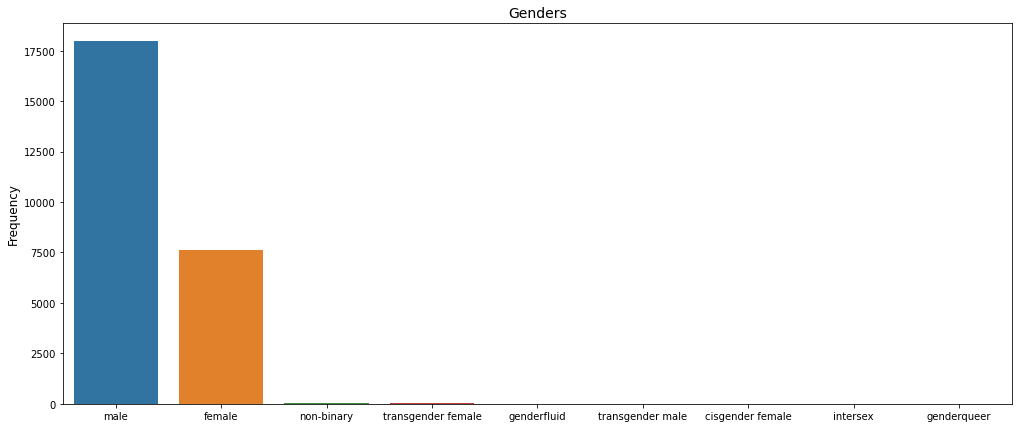

In [ ]:
# Visualisation of gender distribution
fig, ax = plt.subplots(figsize = (17,7))
sns.barplot(x=convert(df_2020["gender"]).value_counts().index,
        y=convert(df_2020["gender"]).value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Genders", size = 14)

A expected, the minorities are almost negligible in comparison to the two main genders. But it is still very intesting to notice their presence even in small numbers. We could make a further analysis on them but first we will concentrate on the repartition between male and female. Unsurprsingly, male speakers are quoted two times more than female ones. 

In [ ]:
# Creation of DataFrame, male speakers
# The gender column contains lists. A mask is created to select values
# upon conditions in the list.
mask_males = df_2020.gender.apply(lambda x: 'male' in x)
males_df = df_2020[mask_males]
males_df.head()

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],[basketball player],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],None,[American football player],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],[lawyer],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],None,[artist],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]
5,2020-01-03-030623,I'm not in medieval times!,Robin Van Persie,[male],[Kingdom of the Netherlands],[association football player],Q2339,2020-01-03 22:32:10,94,[https://www.thesun.co.uk/sport/football/10666...,[The Sun]


In [ ]:
# Creation of DataFrame, female speakers
mask_females = df_2020.gender.apply(lambda x: 'female' in x)
females_df = df_2020[mask_females]
females_df.head()

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],"[film director, screenwriter, writer, film pro...",Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
8,2020-04-08-075398,Your positivity on screen makes so many people...,HOLLY Willoughby,[female],[United Kingdom],"[television presenter, model]",Q1395713,2020-04-08 07:10:04,1,[https://www.thesun.co.uk/tvandshowbiz/1135207...,[The Sun]
12,2020-01-07-028035,I saw Snoop Dogg and given the fact I have met...,Nicole Scherzinger,[female],[United States of America],"[actor, singer, dancer, musician, composer, re...",Q167696,2020-01-07 22:30:07,1,[https://www.thesun.co.uk/tvandshowbiz/1069315...,[The Sun]
26,2020-02-12-041734,I won't be staying by myself tonight.,Kelly Brook,[female],[United Kingdom],"[actor, model, film actor, television presenter]",Q255060,2020-02-12 22:34:08,104,[https://www.thesun.co.uk/tvandshowbiz/1095236...,[The Sun]
29,2020-02-24-048695,"She's got as hammock, going back to my jungle ...",JACQUELINE Jossa,[female],[United Kingdom],[actor],Q6120126,2020-02-24 12:16:46,1,[https://www.thesun.co.uk/tvandshowbiz/1102843...,[The Sun]


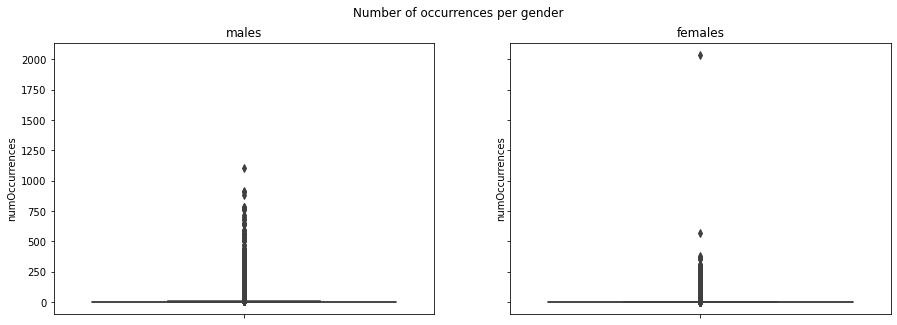

In [ ]:
# Distribution of male and female speakers regarding the number of occurrences of quotes
fig, axs = plt.subplots(1,2, sharey='row')
axs[0].set_title("males")
axs[1].set_title("females")
sns.boxplot(y='numOccurrences', data = males_df, ax = axs[0])
sns.boxplot(y='numOccurrences', data = females_df, ax = axs[1])
fig.suptitle('Number of occurrences per gender')
fig.set_size_inches(15,5)
plt.show()

There are seem to be some wide spread quotes. Let us have a look:

In [ ]:
females_df.loc[females_df.numOccurrences >= 300]

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
2759,2020-01-24-061521,"Of course, this depends on whether this contin...",Chris Witty,[female],[United States of America],"[speed skater, sport cyclist]",Q273505,2020-01-24 16:03:09,354,[http://www.expressandstar.com/news/uk-news/20...,[The Sun]
8012,2020-01-16-021077,gentlemen's club of politics.,Rebecca Long-Bailey,[female],[United Kingdom],"[lawyer, politician]",Q19979355,2020-01-16 22:31:27,375,[http://andoveradvertiser.co.uk/news/national/...,[The Sun]
9484,2020-01-19-037423,That's really why we're here -- to pitch.,Duchess of Sussex,[female],[United States of America],"[actor, model, television actor, patron of the...",Q3304418,2020-01-19 00:00:00,304,[http://feeds.foxnews.com/~r/foxnews/entertain...,[The Sun]
10814,2020-01-24-108786,What we don't know is how far it's going to sp...,Chris Witty,[female],[United States of America],"[speed skater, sport cyclist]",Q273505,2020-01-24 17:01:37,352,[http://ardrossanherald.com/news/18185599.clea...,[The Sun]
10997,2020-02-15-022996,I'm trying to find the words but I can't.,Laura Whitmore,[female],[Ireland],[television presenter],Q6499556,2020-02-15 00:00:00,379,[http://femalefirst.co.uk/tv/news/caroline-fla...,[The Sun]
15169,2020-03-26-049143,protect the public and keep people safe.,Priti Patel,[female],[United Kingdom],[politician],Q575733,2020-03-26 15:43:08,315,[http://www.expressandstar.com/news/uk-news/20...,[The Sun]
15299,2020-02-02-030364,"My first thoughts are with the victims, our br...",Priti Patel,[female],[United Kingdom],[politician],Q575733,2020-02-02 15:35:09,565,[https://globalnews.ca/news/6496241/stabbings-...,[The Sun]
17635,2020-01-08-103116,work to become financially independent.,Duchess of Sussex,[female],[United States of America],"[actor, model, television actor, patron of the...",Q3304418,2020-01-08 00:00:00,2037,[http://kaaltv.com/news/prince-harry-meghan-st...,"[The Sun, The Guardian]"


In [ ]:
males_df.loc[males_df.numOccurrences >= 700]

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
1897,2020-01-07-005600,appears to be standing down.,President Donald Trump,[male],[United States of America],"[business magnate, investor, restaurateur, non...",Q22686,2020-01-07 23:52:00,759,[http://feeds.marketwatch.com/~r/marketwatch/b...,"[The Times, The Sun]"
4209,2020-02-07-059825,make it impossible for me to do my job.,William Barr,[male],None,[engineer],Q16683338,2020-02-07 00:00:00,1105,[http://www.canindia.com/trump-should-stop-twe...,[The Guardian]
5377,2020-02-04-073676,"So, we have to do everything today using avail...",Tedros Adhanom Ghebreyesus,[male],[Ethiopia],"[politician, microbiologist, malariologist]",Q16196017,2020-02-04 14:12:00,785,[https://www.wsbradio.com/lifestyles/atlanta-r...,[The Sun]
7111,2020-01-02-015905,"He should have been taken out many years ago!,",President Donald Trump,[male],[United States of America],"[business magnate, investor, restaurateur, non...",Q22686,2020-01-02 15:27:00,767,[http://timescolonist.com/iran-vows-revenge-fo...,[The Sun]
13195,2020-01-07-083106,"`We do not seek escalation or war, but will de...",Mohammad Javad Zarif,[male],[Iran],"[diplomat, politician]",Q10296812,2020-01-07 00:00:00,781,[http://feeds.foxnews.com/~r/foxnews/world/~3/...,"[The Sun, The Times]"
13470,2020-03-13-021876,"I don't take responsibility at all,",President Donald Trump,[male],[United States of America],"[business magnate, investor, restaurateur, non...",Q22686,2020-03-13 00:00:00,717,[http://digital.vpr.net/post/president-trump-d...,[The Sun]
17236,2020-03-22-038681,we cannot let the cure be worse than the probl...,President Donald Trump,[male],[United States of America],"[business magnate, investor, restaurateur, non...",Q22686,2020-03-22 11:00:00,702,[https://www.duluthnewstribune.com/news/nation...,[The Sun]
19358,2020-01-21-011547,"By all indications, we are going on to New Ham...",Pete Buttigieg,[male],[United States of America],"[politician, military officer, statesperson]",Q7173106,2020-01-21 16:30:26,885,[https://www.inforum.com/news/government-and-p...,[The Guardian]
20023,2020-01-02-068709,weirdos and misfits with odd skills.,Dominic Cummings,[male],[United Kingdom],[political adviser],Q24572712,2020-01-02 00:00:00,773,[http://uk.investing.com/news/economy/wanted-w...,"[The Guardian, The Times]"
20185,2020-01-31-079605,Terrorists seek to divide us and to destroy ou...,Sadiq Khan,[male],[United Kingdom],"[politician, lawyer, solicitor]",Q334155,2020-01-31 00:00:00,914,[http://www.canindia.com/man-shot-dead-after-l...,[The Sun]


Seeing the distribution regarding the number of occurrences of quotes from male and female speakers, we can clearly see a stronger presence of male speakers in the newspapers. This supports the general hypothesis of a domination by men for quotes. This raises further questions for our analysis concerning: The evolution of this domination throughout the years and depending on different countries, the themes aborded by different genders or the representation of gender minorities.

We will look at one last thing. How many quotes are originated from men and female **depending on the newspaper** (for now just our three newspapers)? This will be important for our further analysis.

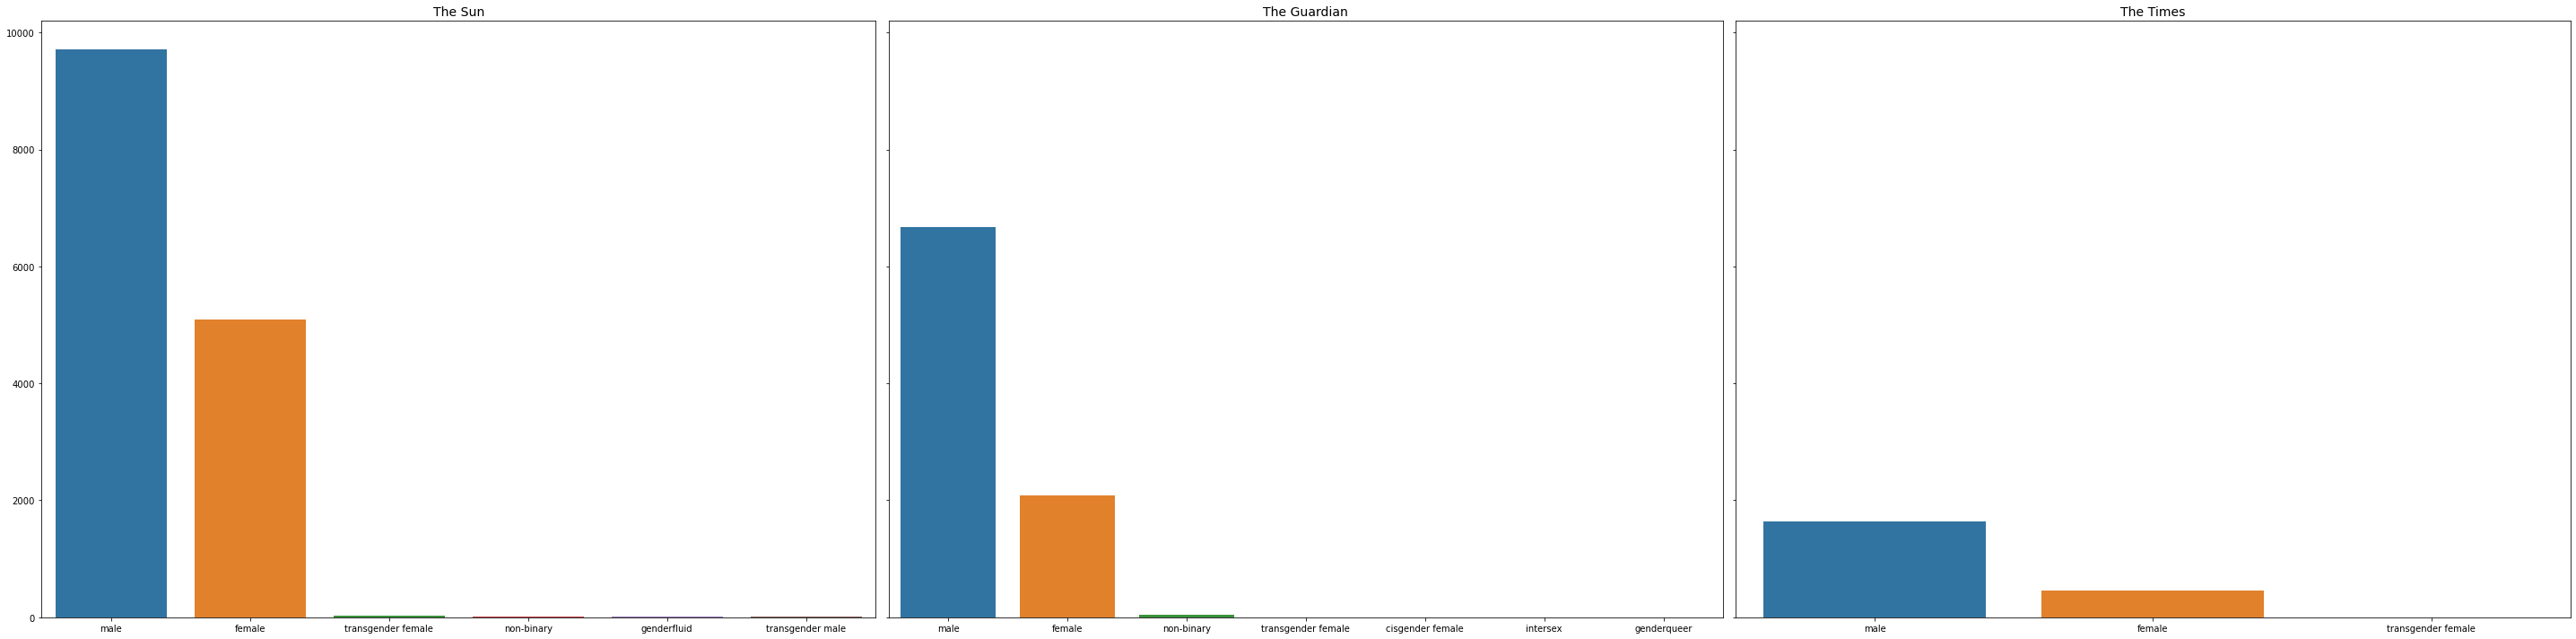

In [ ]:
#mask for each newspaper
mask_sun = df_2020.newspapers.apply(lambda x: 'The Sun' in x)
mask_guardian = df_2020.newspapers.apply(lambda x: 'The Guardian' in x)
mask_times = df_2020.newspapers.apply(lambda x: 'The Times' in x)

# we plot the distribution for each of them
fig, axs = plt.subplots(1,3, sharey='row', figsize = (40,10))

sns.barplot(x=convert(df_2020[mask_sun]['gender']).value_counts().index,
        y=convert(df_2020[mask_sun]['gender']).value_counts().values, ax = axs[0])
sns.barplot(x = convert(df_2020[mask_guardian]['gender']).value_counts().index,
        y=convert(df_2020[mask_guardian]['gender']).value_counts().values, ax = axs[1])
sns.barplot(x=convert(df_2020[mask_times]['gender']).value_counts().index,
        y=convert(df_2020[mask_times]['gender']).value_counts().values, ax = axs[2])

axs[0].set_title("The Sun", size = 14)
axs[1].set_title("The Guardian", size = 14)
axs[2].set_title("The Times", size = 14)
plt.tight_layout()

We can see that all three of newspapers have more quotes (twice as much) written by men than by women. We can also see that The Sun is the most cited newspaper, and The Times seems to include very few gender minorities.